# Airline seat allocation problem

An airlines is trying to decide how to partition a new plane for the Amsterdam-Buenos Aires route. This plane can seat 200 economy class passengers. A section can be created for first class seats but each of these seats takes the space of 2 economy class seats. A business class section can also be created, but each of these seats takes as much space as 1.5 economy class seats. The profit on a first class ticket is, however, three times the profit of an economy ticket, while a business class ticket has a profit of two times an economy ticket's profit. Once the plane is partitioned into these seating classes, it cannot be changed. The airlines knows, however, that the plane will not always be full in each section. 

## Installation and Imports

In [ ]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

In [206]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd

## Model 1. Extensive Form of a Stochastic Program

The airline has decided that three scenarios will occur with about the same frequency: 

* (1) weekday morning and evening traffic, 
* (2) weekend traffic, 
* (3) weekday midday traffic. 

Under Scenario 1, they think they can sell as many as 20 first class tickets, 50 business class tickets, and 200 economy tickets. Under Scenario 2, these figures are $10 , 24 $, and $175$, while under Scenario 3, they are $6 , 10$, and $150$. The following table reports the forecast demand in the three scenarios.

| Scenario | First class seats | Business class seats | Economy class seats |
| :-- | :-: | :-: | :-: |
| (1) weekday morning and evening | 20 | 50 | 200 |
| (2) weekend | 10 | 24 | 175 |
| (3) weekday midday | 6 | 10 | 150 |

Despite these estimates, the airline will not sell more tickets than seats in each of the sections (hence no overbooking strategy).

Implement and solve the extensive form of the stochastic program for the optimal seat allocation aiming to maximize the airline profit.

## Price and Scenario Data

In [282]:
# seat price and size data
seat_data = pd.DataFrame({
    "F": {"price factor": 3.0, "seat factor": 2.0},
    "B": {"price factor": 2.0, "seat factor": 1.5},
    "E": {"price factor": 1.0, "seat factor": 1.0},
}).T

display(seat_data)

,price factor,seat factor
F,3.0,2.0
B,2.0,1.5
E,1.0,1.0


In [285]:
# scenario data
scenario_data = pd.DataFrame({
    "morning and evening": {'F': 20, 'B': 50, 'E': 200},
    "weekend": {'F': 10, 'B': 24, 'E': 175},
    "midday": {'F':  6, 'B': 10, 'E': 150}
}).T

display(scenario_data)

,F,B,E
morning and evening,20,50,200
weekend,10,24,175
midday,6,10,150


<AxesSubplot:title={'center':'Demand Scenarios'}>

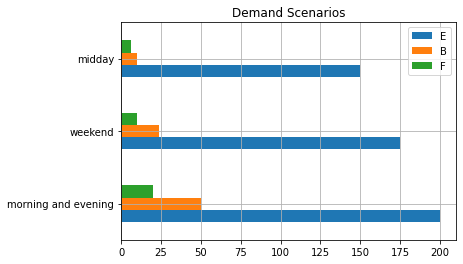

In [286]:
scenario_data[["E", "B", "F"]].plot(kind="barh", rot=0, stacked=False, title="Demand Scenarios", grid=True)

## Pyomo Model

Optimal objective value (in units of economy ticket price): 209


,F,B,E
seat allocation,10.0,20.0,150.0
equivalent seat allocation,20.0,30.0,150.0


,F,B,E
morning and evening,10.0,20.0,150.0
weekend,10.0,20.0,150.0
midday,6.0,10.0,150.0


,F,B,E
morning and evening,0.0,0.0,0.0
weekend,0.0,0.0,0.0
midday,4.0,10.0,0.0


,F,B,E
morning and evening,10.0,30.0,50.0
weekend,0.0,4.0,25.0
midday,0.0,0.0,0.0


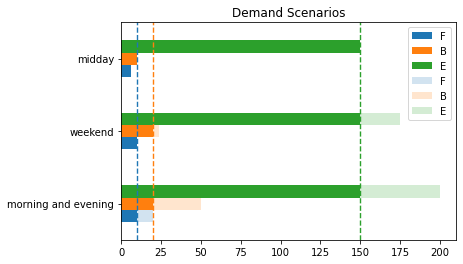

In [362]:
def airline(total_seats, seat_data, scenario_data):

    m = pyo.ConcreteModel()
    
    m.classes = pyo.Set(initialize=seat_data.index)
    m.scenarios = pyo.Set(initialize=scenario_data.index)

    # first stage variables and constraints
    
    m.seats = pyo.Var(m.classes, domain=pyo.NonNegativeIntegers) 

    @m.Expression(m.classes)
    def equivalent_seats(m, c):
        return m.seats[c] * seat_data.loc[c, "seat factor"]

    @m.Constraint()
    def plane_seats(m):
        return sum(m.equivalent_seats[c] for c in m.classes) <= total_seats

    # second stage variables and constraints
    
    m.sell = pyo.Var(m.classes, m.scenarios, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.classes, m.scenarios)
    def demand(m, c, s):
        return m.sell[c, s] <= scenario_data.loc[s, c]

    @m.Constraint(m.classes, m.scenarios)
    def sell_limit(m, c, s):
        return m.sell[c, s] <= m.seats[c]

    # objective
    
    @m.Expression()
    def second_stage_profit(m):
        total =  sum(sum(m.sell[c, s] * seat_data.loc[c, "price factor"] for s in m.scenarios) for c in m.classes)
        return total / len(m.scenarios)

    @m.Objective(sense=pyo.maximize)
    def total_expected_profit(m):
        return m.second_stage_profit
    
    return m

def report(m, seat_data, scenario_data):
    # report objective
    print(f"Optimal objective value (in units of economy ticket price): {m.total_expected_profit():.0f}")
    
    # report seat allocation
    seats = pd.DataFrame({
        "seat allocation":  {c: m.seats[c]() for c in m.classes},
        "equivalent seat allocation": {c: m.equivalent_seats[c].expr() for c in m.classes}
    }).T
    
    # report seats sold
    sold = pd.DataFrame({c: {s: m.sell[c, s]() for s in m.scenarios} for c in m.classes})
    
    # report seats unsold
    unsold = pd.DataFrame({c: {s: m.seats[c]() - m.sell[c, s]() for s in m.scenarios} for c in m.classes})
    #unsold.replace(to_replace=0.0, value="-", inplace=True)
    
    # report spillage (unsatisfied demand)
    spillage = pd.DataFrame({c: {s: scenario_data.loc[s, c] - m.sell[c, s]() for s in m.scenarios} for c in m.classes})
    #spillage.replace(to_replace=0.0, value="-", inplace=True)    
     
    return seats, sold, unsold, spillage

    
m = airline(200, seat_data, scenario_data)
pyo.SolverFactory('cbc').solve(m)
seats, sold, unsold, spillage = report(m, seat_data, scenario_data);
display(seats)
display(sold)
display(unsold)
display(spillage)

ax = sold[m.classes].plot(kind="barh", rot=0, stacked=False, title="Demand Scenarios")
scenario_data[m.classes].plot(ax=ax, kind="barh", rot=0, stacked=False, title="Demand Scenarios", alpha=0.2)
for c in m.classes:
    ax.plot([m.seats[c]()] * 2, ax.get_ylim(), "--", lw=1.4)

## Model 2. Chance Constraints

The airline wishes a special guarantee for its clients enrolled in its loyalty program. In particular, it wants $98\%$ probability to cover the demand of first-class seats and $95\%$ probability to cover the demand of business class seats (by clients of the loyalty program). First-class passengers are covered if they can purchase a first-class seat. Business class passengers are covered if they purchase a business class seat or upgrade to a first-class seat. 

Assume weekday demands of loyalty-program passengers are normally distributed as $\xi_F \sim \mathcal N(\mu_F, \sigma_F^2)$ and $\xi_B \sim \mathcal N(\mu_B, \sigma_B^2)$ for first-class and business, respectively. Assume that the demands for first-class and business class seats are independent.

Let $x_F$ be the number of first-class seats and $x_B$ the number of business seats. The probabilistic constraints are

$$
\mathbb P(x_F \geq \xi_F ) \geq 0.98, \qquad \text{ and } \qquad \mathbb P(x_F + x_B \geq \xi_F + \xi_B ) \geq 0.95.
$$

These are can be written equivalently as linear constraints, specifically 

$$
\frac{x_F - \mu_F}{\sigma_F} \geq 2.054 \qquad \text{ and } \qquad \frac{(x_F + x_B) - (\mu_F + \mu_B)}{\sqrt{\sigma_F^2 + \sigma_B^2}} \geq 1.645.
$$

| | $\mu$ | $\sigma$ |
| :--: | :--: | :--: |
| F | 12 | 4 |
| B | 28 | 8 |
| E | 175 | 20 |


Add to your implementation of the extensive form the two equivalent deterministic constraints corresponding to the two chance constraints and find the new optimal solution meeting these additional constraints. How is it different from the previous one?

In [363]:
mu = scenario_data.mean()
sigma = {"F": 4, "B": 8, "E": 20}
display(pd.DataFrame({"mu": mu, "sigma": sigma}))

,mu,sigma
F,12.0,4
B,28.0,8
E,175.0,20


Optimal objective value (in units of economy ticket price): 188


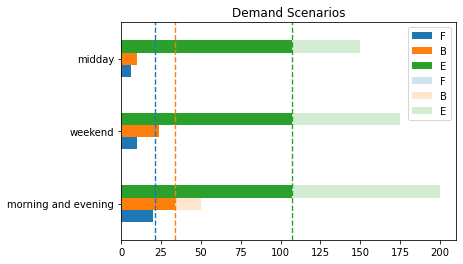

In [398]:
m = airline(200, seat_data, scenario_data)

m.loyaltyF = pyo.Constraint(expr = m.seats['F'] - mu['F'] >= 2.054 * sigma['F'])
m.loyaltyFB = pyo.Constraint(expr = m.seats['F'] + m.seats['B'] - (mu['F'] + mu['B']) >= 1.645 * np.sqrt(sigma['F']**2 + sigma['B']**2))

pyo.SolverFactory('cbc').solve(m)
seats, sold, unsold, spillage = report(m, seat_data, scenario_data)

ax = sold[m.classes].plot(kind="barh", rot=0, stacked=False, title="Demand Scenarios")
scenario_data[m.classes].plot(ax=ax, kind="barh", rot=0, stacked=False, title="Demand Scenarios", alpha=0.2)
for c in m.classes:
    ax.plot([m.seats[c]()] * 2, ax.get_ylim(), "--", lw=1.4)


## Model 3. Sample Average Approximation

Now assume the ticket demand for the three categories is captured by a $3$-dimensional multivariate normal distribution mean $\mu=(\mu_F, \mu_B, \mu_E)$, variances $(\sigma_F^2, \sigma_B^2, \sigma_E^2)$, and a symmetric correlation matrix 

$$
P = \left(
\begin{array}{ccc}
1 & \rho_{FB} & \rho_{FE} \\
\rho_{BF} & 1 & \rho_{BE}\\
\rho_{EF} & \rho_{EB} & 1 \\
\end{array}
\right)
$$

The covariance matrix is given by $\Sigma = \text{diag}(\sigma)\ P\ \text{diag}(\sigma)$ or

$$
\Sigma= \left(
\begin{array}{ccc}
 \sigma_F^2 & \rho_{FB}\sigma_F\sigma_B & \rho_{FE}\sigma_F\sigma_E \\
\rho_{BF}\sigma_B\sigma_F & \sigma_B^2 & \rho_{BE}\sigma_B\sigma_E\\
\rho_{EF}\sigma_E\sigma_F & \rho_{EB}\sigma_E\sigma_B & \sigma_E^2 \\
\end{array}
\right)
$$

We will assume $\rho_FB = 0.6$, $\rho_{BE} = 0.4$ and $\rho_{FE} = 0.2$.

Solve approximately the airline seat allocation problem (with the loyalty constraints) using the Sample Average Approximation method. More specifically, sample $N=1000$ points from the multivariate normal distribution and solve the extensive form for the stochastic LP resulting from those $N=1000$ scenarios.

### Scenario Generation


sample means
F     11.917
B     27.877
E    174.630
dtype: float64

sample standard deviations
F     3.915794
B     7.984336
E    19.812815
dtype: float64

sample covariance
           F          B           E
F  15.333444  18.987779   13.020310
B  18.987779  63.749621   55.100591
E  13.020310  55.100591  392.547648


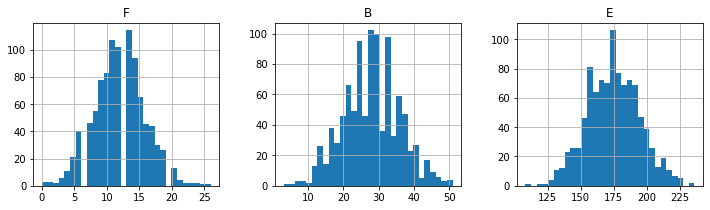

In [459]:
# create covariance matrix
P = np.array([[1, 0.6, 0.2], [0.6, 1, 0.4], [0.2, 0.4, 1]])
s = np.array(list(sigma.values()))
S = np.diag(s) @ P @ np.diag(s)

# create samples
N = 1000
np.random.seed(1)
samples = np.random.multivariate_normal(list(mu), S, N).round()
saa_data = pd.DataFrame(samples, columns=seat_data.index)
saa_data[saa_data < 0] = 0
saa_data.hist(bins=30, layout=(1, 3), figsize=(12, 3))

print("\nsample means")
print(saa_data.mean())

print("\nsample standard deviations")
print(saa_data.std())

print("\nsample covariance")
print(saa_data.cov())

### Solution

In [433]:
m = airline(200, seat_data, saa_data)

m.loyaltyF = pyo.Constraint(expr = m.seats['F'] - mu['F'] >= 2.054 * sigma['F'])
m.loyaltyFB = pyo.Constraint(expr = m.seats['F'] + m.seats['B'] - (mu['F'] + mu['B']) >= 1.645 * np.sqrt(sigma['F']**2 + sigma['B']**2))

pyo.SolverFactory('cbc').solve(m)
seats, sold, unsold, spillage = report(m, seat_data, saa_data)

display(seats)

Optimal objective value (in units of economy ticket price): 196


,F,B,E
seat allocation,21.0,34.0,107.0
equivalent seat allocation,42.0,51.0,107.0



Sold Seats


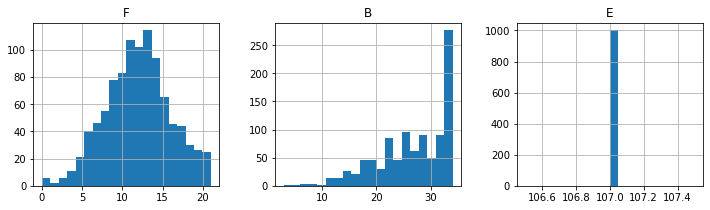

In [434]:
print("\nSold Seats")
sold.hist(layout=(1, 3), figsize=(12, 3), bins=20);


Unsold Seats


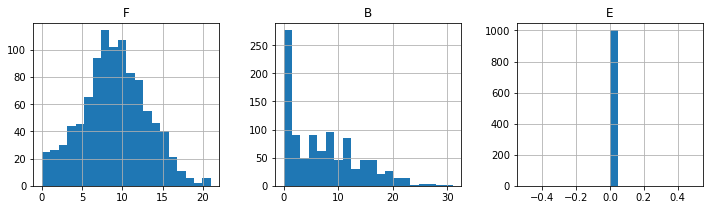

In [435]:
print("\nUnsold Seats")
unsold.hist(layout=(1, 3), figsize=(12, 3), bins=20);


Spillage


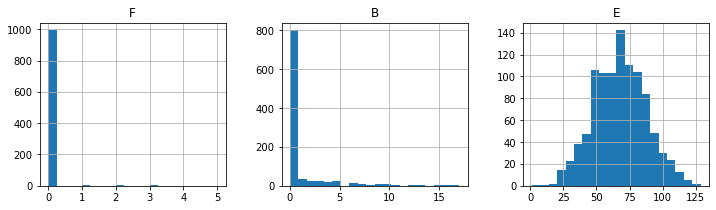

In [438]:
print("\nSpillage")
spillage.hist(layout=(1, 3), figsize=(12, 3), bins=20);

## Model 4. Sample Average Approximation with Chance Constraints

In [452]:
m = airline(200, seat_data, saa_data)

m.yF = pyo.Var(m.scenarios, domain=pyo.Binary)
m.yFB = pyo.Var(m.scenarios, domain=pyo.Binary)

@m.Constraint(m.scenarios)
def loyaltyF(m, s):
    return m.seats['F'] >= saa_data.loc[s, 'F'] - 200 * m.yF[s]

@m.Constraint()
def loyaltyF_disjuct(m):
    return pyo.summation(m.yF) <= 0.02 * N

@m.Constraint(m.scenarios)
def loyaltyFB(m, s):
    return m.seats['F'] + m.seats['B'] >= saa_data.loc[s, 'F'] + saa_data.loc[s, 'B'] - 200 * m.yFB[s]

@m.Constraint()
def loyaltyFB_disjuct(m):
    return pyo.summation(m.yFB) <= 0.05 * N

pyo.SolverFactory('cbc').solve(m)
seats, sold, unsold, spillage = report(m, seat_data, saa_data)

display(seats)

Optimal objective value (in units of economy ticket price): 194


,F,B,E
seat allocation,20.0,38.0,103.0
equivalent seat allocation,40.0,57.0,103.0



Sold Seats


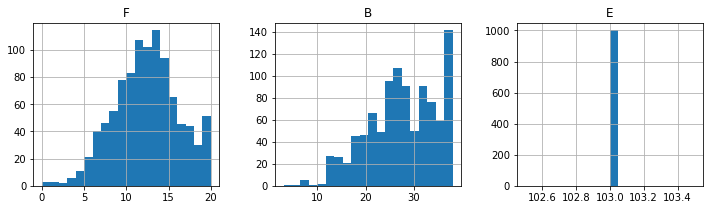

In [453]:
print("\nSold Seats")
sold.hist(layout=(1, 3), figsize=(12, 3), bins=20);


Unsold Seats


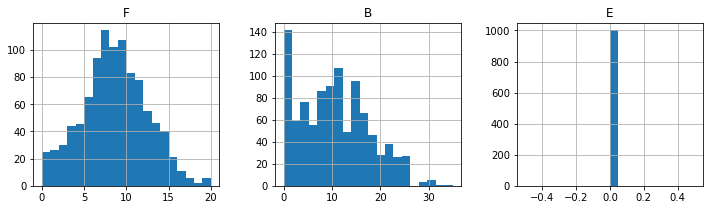

In [454]:
print("\nUnsold Seats")
unsold.hist(layout=(1, 3), figsize=(12, 3), bins=20);


Spillage


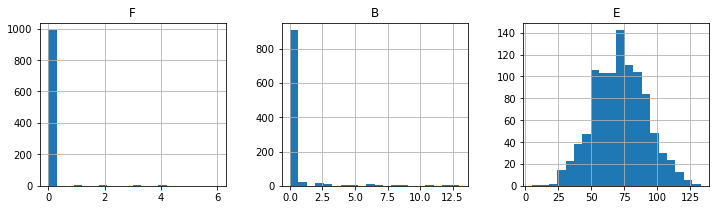

In [455]:
print("\nSpillage")
spillage.hist(layout=(1, 3), figsize=(12, 3), bins=20);